# Switch to GPU using runtime tab

# Increase prediction speed with OpenCV - (https://learnopencv.com/how-to-convert-a-model-from-pytorch-to-tensorrt-and-speed-up-inference/)
# Use new training images

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd "gdrive/MyDrive/Colab Notebooks/Official"

[Errno 2] No such file or directory: 'gdrive/MyDrive/Colab Notebooks/Official'
/content/gdrive/MyDrive/Colab Notebooks/Official


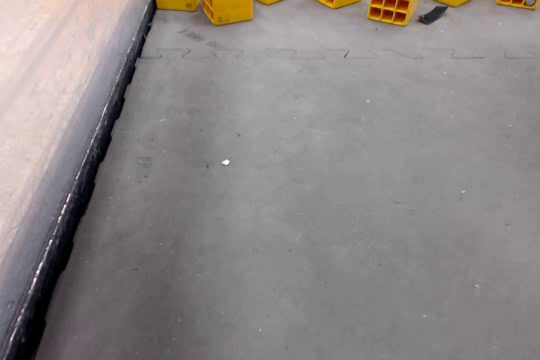

In [ ]:
from PIL import Image
from PIL import ImageDraw
import pandas as pd

image = Image.open("./images/image_0.jpg")
image

# images should be 800 * 400

In [ ]:
labels = pd.read_csv("./labels.csv", names=["class", "xmin", "ymin", "box_width", "box_height", "filename", "width", "height"])
labels['xmax'] = labels["xmin"] + labels["box_width"]
labels['ymax'] = labels["ymin"] + labels["box_height"]
labels.drop(["box_width", "box_height"], inplace=True, axis=1)
# labels.to_csv("./labels.csv")

labels.head()

,class,xmin,ymin,filename,width,height,xmax,ymax
0,weighted,200,10,image_100.jpg,540,360,262,73
1,weighted,266,0,image_100.jpg,540,360,316,41
2,unweighted,336,8,image_100.jpg,540,360,396,70
3,unweighted,380,22,image_100.jpg,540,360,446,85
4,weighted,199,0,image_101.jpg,540,360,258,47


In [ ]:
# %%bash
# cd "gdrive/MyDrive/Colab Notebooks/Official"
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.3.0
# cp references/detection/utils.py ../
# cp references/detection/transforms.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_utils.py ../

In [ ]:
import pycocotools
import numpy as np
import torch
import torch.utils.data
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import os

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

base_classes = np.array(["","unweighted", "weighted"])
box_colors = np.array(["","blue", "pink"])

le.fit(base_classes)

def parse_one_annot(path_to_data_file, filename):
    # data = path_to_data_file (this line can only be done if I resave labels.csv)
    data = labels
    boxes_array = data[data["filename"] == filename][["xmin", "ymin","xmax", "ymax"]].values
    classes = data[data["filename"] == filename]["class"].values
    classes = torch.tensor(le.transform(classes), dtype=torch.int64)

    return (boxes_array, classes)

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "images")))
        self.path_to_data_file = data_file
    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        box_list, labels = parse_one_annot(self.path_to_data_file, self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
        
    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = ImageDataset(root= "./", data_file = "./labels.csv")
dataset.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=540x360 at 0x7F571A4BD150>,
 {'area': tensor([]),
  'boxes': tensor([], size=(0, 4)),
  'image_id': tensor([0]),
  'iscrowd': tensor([], dtype=torch.int64),
  'labels': tensor([], dtype=torch.int64)})

In [ ]:
def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
    return model

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = ImageDataset(root= "./", data_file= "./labels.csv", transforms = get_transform(train=True))
dataset_test = ImageDataset(root= "./", data_file= "./labels.csv", transforms = get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0, collate_fn=utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 105 examples, 65 are training and 40 testing


In [ ]:
dataset_test[1]

(tensor([[[0.8745, 0.8745, 0.8745,  ..., 0.5451, 0.5373, 0.5333],
          [0.8745, 0.8745, 0.8706,  ..., 0.4941, 0.4863, 0.4824],
          [0.8627, 0.8627, 0.8627,  ..., 0.4078, 0.4000, 0.3922],
          ...,
          [0.3373, 0.3333, 0.3176,  ..., 0.5804, 0.5804, 0.5804],
          [0.3137, 0.2863, 0.2902,  ..., 0.5804, 0.5804, 0.5804],
          [0.3216, 0.2588, 0.2941,  ..., 0.5804, 0.5804, 0.5804]],
 
         [[0.7647, 0.7647, 0.7647,  ..., 0.5373, 0.5294, 0.5255],
          [0.7647, 0.7647, 0.7608,  ..., 0.4863, 0.4784, 0.4745],
          [0.7647, 0.7647, 0.7647,  ..., 0.4000, 0.3922, 0.3843],
          ...,
          [0.3255, 0.3216, 0.2941,  ..., 0.5647, 0.5647, 0.5647],
          [0.3020, 0.2745, 0.2667,  ..., 0.5647, 0.5647, 0.5647],
          [0.3098, 0.2471, 0.2706,  ..., 0.5647, 0.5647, 0.5647]],
 
         [[0.7529, 0.7529, 0.7529,  ..., 0.5804, 0.5725, 0.5686],
          [0.7529, 0.7529, 0.7490,  ..., 0.5294, 0.5216, 0.5176],
          [0.7490, 0.7490, 0.7490,  ...,

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes: weighted and unweighted blocks
num_classes = len(base_classes)

# get the model using our helper function
model = get_model(num_classes+1)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-3, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# TRAIN MODEL

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/22]  eta: 0:00:51  lr: 0.000049  loss: 1.3196 (1.3196)  loss_classifier: 1.1686 (1.1686)  loss_box_reg: 0.1346 (0.1346)  loss_objectness: 0.0133 (0.0133)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 2.3353  data: 0.0338  max mem: 3867
Epoch: [0]  [10/22]  eta: 0:00:27  lr: 0.000524  loss: 1.1819 (1.1373)  loss_classifier: 0.8491 (0.8066)  loss_box_reg: 0.2750 (0.2855)  loss_objectness: 0.0200 (0.0402)  loss_rpn_box_reg: 0.0051 (0.0050)  time: 2.2908  data: 0.0407  max mem: 4131
Epoch: [0]  [20/22]  eta: 0:00:04  lr: 0.001000  loss: 0.8280 (0.8148)  loss_classifier: 0.3854 (0.5346)  loss_box_reg: 0.2750 (0.2495)  loss_objectness: 0.0128 (0.0266)  loss_rpn_box_reg: 0.0021 (0.0042)  time: 2.2780  data: 0.0376  max mem: 4131
Epoch: [0]  [21/22]  eta: 0:00:02  lr: 0.001000  loss: 0.6595 (0.7779)  loss_classifier: 0.3517 (0.5103)  loss_box_reg: 0.2566 (0.2381)  loss_objectness: 0.0092 (0.0255)  loss_rpn_box_reg: 0.0019 (0.0040)  time: 2.2395  data: 0.0369  max mem: 4131
Epoch: [

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

idxs = 20

for idx in range(idxs):
  print(f"Image {str(idx)}")
  img, _ = dataset_test[idx]
  label_boxes = np.array(dataset_test[idx][1]["boxes"])
  print("OFFICIAL LABELS", dataset_test[idx][1]["labels"])
  score_threshold = 0.2

  #put the model in evaluation mode
  model.eval()

  with torch.no_grad():
      prediction = model([img.to(device)])

  # print all labels in image
  print([base_classes[elem] for idx, elem in enumerate(prediction[0]["labels"]) if prediction[0]["scores"][idx] > score_threshold])
  print(prediction[0]["labels"])

  image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
  draw = ImageDraw.Draw(image)

  # draw groundtruth
  # for elem in range(len(label_boxes)):
  #     draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]), (label_boxes[elem][2], label_boxes[elem][3])],  outline ="black", width =3)

  for element in range(len(prediction[0]["boxes"])):
      boxes = prediction[0]["boxes"][element].cpu().numpy()
      label = prediction[0]["labels"][element]
      score = np.round(prediction[0]["scores"][element].cpu().numpy(), decimals= 4)
      if score > score_threshold:
          draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline = box_colors[label], width =2)
          draw.text((boxes[0], boxes[1]), text = str(base_classes[label]))
          
  display(image)

NameError: ignored

#SAVE MODEL

In [ ]:
torch.save(model.state_dict(), "./model.pth")

In [ ]:
# # TEST ON RANDOM IMAGE

# import requests
# image_url = "./images/image_0.jpg"

# im = Image.open(image_url)
# # im = im.resize((768,1024))

# from torchvision import transforms
# pil_to_tensor = transforms.ToTensor()(im)

# with torch.no_grad():
#   prediction = model([pil_to_tensor.to(device)])

# print(prediction)

# image = Image.fromarray(pil_to_tensor.mul(255).permute(1, 2,0).byte().numpy())
# draw = ImageDraw.Draw(image)

# # draw groundtruth (don't do this when using random images)
# for elem in range(len(label_boxes)):
#     draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]), (label_boxes[elem][2], label_boxes[elem][3])],  outline ="black", width =3)

# for element in range(len(prediction[0]["boxes"])):
#     boxes = prediction[0]["boxes"][element].cpu().numpy()
#     label = prediction[0]["labels"][element]
#     score = np.round(prediction[0]["scores"][element].cpu().numpy(), decimals= 4)
#     if score > 0.4:
#         draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
#         outline = box_colors[label], width =3)
#         draw.text((boxes[0], boxes[1]), text = str(score))
        
# image